<center> 
    <div style="font-size: 40px;">
        <strong>
            <U>Projet IA HumanForYou </U>
        </strong>
    </div>
</center>

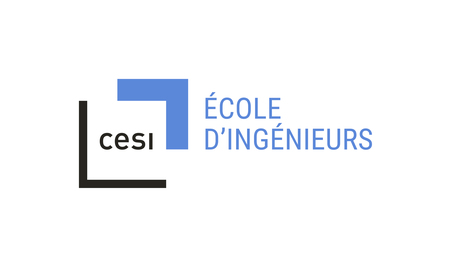


<center> 
    GIRARD-TISSIER Ugo
     | 
    GISLARD Enzo
     | 
    GUESMIA Abdelrahmane
     | 
    CASENOVE Antoine
</center>

In [1]:
#import généraux
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Introduction

L'entreprise de produits pharmaceutiques HumanForYou basée en Inde emploie environ 4000 personnes. Cependant, chaque année elle subit un turn-over d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi.

La direction trouve que ce niveau de turn-over n'est pas bon pour l'entreprise car :

* Les projets sur lesquels étaient les employés quittant la société prennent du retard ce qui nuit à la réputation de l'entreprise auprès de ses clients et partenaires.

* Un service de ressources humaines de taille conséquente doit être conservé car il faut avoir les moyens de trouver les nouvelles recrues.

* Du temps est perdu à l'arrivée des nouveaux employés car ils doivent très souvent être formés et ont besoin de temps pour devenir pleinement opérationnels dans leur nouvel environnement.

Le direction nous fait donc appel pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

# 2. Préparation des données

### A. Chargement des jeux de données

Les données fournies par HumanForYou ont, dans un premier temps, été téléchargées et placées dans le répertoire `datasets`.

Nous allons maintenant créer une fonction utilisant [`Pandas`](https://pandas.pydata.org/) qui s'occupe de charger les données en mémoire dans un `Pandas DataFrame`.

In [2]:
import os

def load_datasets(path, file_name):
    csv_path = os.path.join(path, file_name)
    return pd.read_csv(csv_path)

Il est maintenant possible de charger nos données pour chaque fichier CSV transmis par HumanForYou

In [3]:
general_data = load_datasets("datasets", "general_data.csv")
manager_survey_data = load_datasets("datasets", "manager_survey_data.csv")
employee_survey_data = load_datasets("datasets", "employee_survey_data.csv")
in_time_data = load_datasets("datasets", "in_time.csv")
out_time_data = load_datasets("datasets", "out_time.csv")

Nous allons afficher les premières lignes de nos diffèrents tableaux `Pandas` pour en faire une première approche

In [4]:
general_data.head(2).style

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.000000,Y,11,8,0,1.000000,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.000000,Y,23,8,1,6.000000,3,5,1,4


In [5]:
manager_survey_data.head(2).style

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4


In [6]:
employee_survey_data.head(2).style

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.000000,4.000000,2.000000
1,2,3.000000,2.000000,4.000000


In [7]:
in_time_data.head(2).style

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,nan,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,nan,2015-01-15 10:01:24,2015-01-16 10:19:08,nan,2015-01-20 09:50:34,2015-01-21 09:49:42,2015-01-22 09:47:45,2015-01-23 09:23:44,nan,2015-01-27 09:50:37,2015-01-28 09:56:13,2015-01-29 09:53:47,2015-01-30 10:09:26,2015-02-02 09:38:43,2015-02-03 10:23:38,2015-02-04 09:48:37,2015-02-05 09:52:36,2015-02-06 09:53:23,2015-02-09 10:01:45,2015-02-10 10:14:18,2015-02-11 10:18:44,2015-02-12 10:10:35,2015-02-13 09:13:07,2015-02-16 10:14:02,2015-02-17 10:03:08,2015-02-18 10:23:06,nan,2015-02-20 09:54:56,2015-02-23 09:46:59,2015-02-24 10:11:18,2015-02-25 09:52:36,2015-02-26 09:56:33,2015-02-27 09:58:46,2015-03-02 10:19:43,2015-03-03 10:08:37,2015-03-04 10:05:38,nan,2015-03-06 09:55:53,2015-03-09 10:28:34,2015-03-10 09:47:30,2015-03-11 09:48:59,2015-03-12 10:10:51,2015-03-13 10:07:18,nan,2015-03-17 10:05:22,2015-03-18 10:28:21,2015-03-19 10:01:52,2015-03-20 10:37:49,2015-03-23 10:11:19,2015-03-24 10:33:19,2015-03-25 09:41:35,nan,2015-03-27 09:47:30,2

In [8]:
out_time_data.head(2).style

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-05,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-01,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,nan,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,nan,2015-01-15 17:22:13,2015-01-16 17:35:11,nan,2015-01-20 16:37:07,2015-01-21 16:55:24,2015-01-22 16:50:47,2015-01-23 17:00:01,nan,2015-01-27 17:28:22,2015-01-28 17:03:21,2015-01-29 17:18:36,2015-01-30 17:00:25,2015-02-02 16:32:49,2015-02-03 17:35:49,2015-02-04 17:24:56,2015-02-05 17:26:31,2015-02-06 17:21:35,2015-02-09 17:37:50,2015-02-10 17:30:20,2015-02-11 17:30:19,2015-02-12 17:36:42,2015-02-13 16:25:26,2015-02-16 17:50:23,2015-02-17 17:28:06,2015-02-18 18:13:29,nan,2015-02-20 17:44:52,2015-02-23 17:13:27,2015-02-24 17:24:48,2015-02-25 17:27:37,2015-02-26 17:08:36,2015-02-27 17:21:55,2015-03-02 17:29:08,2015-03-03 16:54:12,2015-03-04 17:50:18,nan,2015-03-06 17:44:47,2015-03-09 17:53:05,2015-03-10 16:42:53,2015-03-11 16:58:39,2015-03-12 17:15:39,2015-03-13 17:25:55,nan,2015-03-17 17:00:16,2015-03-18 17:40:13,2015-03-19 17:52:44,2015-03-20 17:47:34,2015-03-23 17:48:18,2015-03-24 17:48:26,2015-03-25 17:08:19,nan,2015-03-27 17:20:51,2

### B. Construction d'un unique dataset

Pour éviter de se compliquer la tache, il est preferable de travailler avec un seul et unique dataset. Or l'entreprise nous a transmis des jeux de données qui sont liés à leurs employés. Nous allons donc essayer de "joindre" ces jeux de données en un seul tableau.

Nous vérifions dans un premier si nos tableaux `Pandas` contiennent le même nombre de ligne

In [9]:
print("Dimensions general_data :", general_data.shape)
print("Dimensions manager_survey_data :", manager_survey_data.shape)
print("Dimensions employee_survey_data :", employee_survey_data.shape)
print("Dimensions in_time_data :", in_time_data.shape)
print("Dimensions out_time_data :", out_time_data.shape)

Dimensions general_data : (4410, 24)
Dimensions manager_survey_data : (4410, 3)
Dimensions employee_survey_data : (4410, 4)
Dimensions in_time_data : (4410, 262)
Dimensions out_time_data : (4410, 262)


Bonne nouvelle! Les tableaux contiennent tous le même nombre de ligne. Il semblerait que nous ayons donc une ligne par employé dans chaque tableau. 

Nous pouvons commencer par essayer de "joindre" les tableaux `general_data` et `manager_survey_data`. En effet, ces deux tableaux ont une colonne similaire nommée `EmployeeID` qui semble la plus adaptée à une jointure. 

Avant de faire la jointure, nous allons vérifier qu'il n'y a pas de doublons sur cette donnée car cela pourrait planter notre jointure.

In [10]:
print("Nombre de ligne unique general_data : ", general_data.EmployeeID.unique().shape)
print("Nombre de ligne unique manager_survey_data : ", manager_survey_data.EmployeeID.unique().shape)

Nombre de ligne unique general_data :  (4410,)
Nombre de ligne unique manager_survey_data :  (4410,)


Parfait, le nombre d'élément unique est le même, nous pouvons faire la jointure sur cette colonne

In [11]:
dataset = general_data.join(manager_survey_data.set_index('EmployeeID'), how="inner", on="EmployeeID")
print ("Dimensions après jointure : ", dataset.shape)

Dimensions après jointure :  (4410, 26)


Nous obtenons bien le même nombre de ligne et nous avons bien les 24 colonnes de `general_data` plus les 2 colonnes de `manager_survey_data` (`EmployeeID` n'ayant été gardée qu'une seule fois lors de la jointure) 

Nous pouvons maintenant réexécuter cette procédure avec les tableaux `dataset` et `employee_survey_data`

In [12]:
print("Nombre de ligne unique employee_survey_data : ", employee_survey_data.EmployeeID.unique().shape)

Nombre de ligne unique employee_survey_data :  (4410,)


In [13]:
dataset = dataset.join(employee_survey_data.set_index('EmployeeID'), how="inner", on="EmployeeID")
print ("Dimensions après jointure : ", dataset.shape)

Dimensions après jointure :  (4410, 29)


Les tableaux `in_time_data` et `out_time_data` ne contiennent pas de colonne nommée `EmployeeID`. Cependant la première colonne de ces deux tableaux y ressemble beaucoup. Nous allons vérifier si celle-ci contient des données uniques, si oui alors nous utiliserons cette colonne en tant qu'ID de jointutre.

In [14]:
in_time_data.rename( columns={'Unnamed: 0':'EmployeeID'}, inplace=True )
out_time_data.rename( columns={'Unnamed: 0':'EmployeeID'}, inplace=True )
print("Nombre de ligne unique in_time_data : ", in_time_data.EmployeeID.unique().shape)
print("Nombre de ligne unique out_time_data : ", out_time_data.EmployeeID.unique().shape)

Nombre de ligne unique in_time_data :  (4410,)
Nombre de ligne unique out_time_data :  (4410,)


In [15]:
dataset = dataset.join(in_time_data.set_index('EmployeeID'), how="inner", on="EmployeeID")
dataset = dataset.join(out_time_data.set_index('EmployeeID'), how="inner", on="EmployeeID", lsuffix='_in', rsuffix='_out')

In [16]:
dataset.head().style

Notre variable `dataset` est maintenant le résultat de la jointure de tout les tableaux fournit par HumanForYou, ce qui sera beaucoup plus simple à exploiter pour plus tard.

### C. Exploration du jeu de données

Nous allons, dans cette partie, étudier plus en détails les données qui nous ont été fournies par l'entreprise. Dans un premier temps nous allons nous focaliser sur les données 28 premières colonnes et ainsi éliminer toutes les colonnes liées aux entrées / sorties des employés pour "allèger" notre dataset.

In [17]:
dataset_without_in_out = dataset.drop(dataset.iloc[:,29:],1)
dataset_without_in_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

#### C.1 Question d'éthique

La première question à traiter avant tout travail sur un dataset est bien évidemment la question de `l'éthique`. En effet, nous ne pouvons pas nous permettre de travailler sur des données pouvant amener à des conflits basés sur l'éthique.

Ainsi, bien que certaines de ces données peuvent peut être jouer un rôle important dans notre étude, nous décidons de supprimer les colonnes suivantes pour éviter tout problème :

* Gender
* MaritalStatus            

In [18]:
dataset_without_in_out.drop("Gender", axis=1, inplace=True)
dataset_without_in_out.drop("MaritalStatus", axis=1, inplace=True)

#### C.2 Recherche des données inutiles

Nous allons commencer par afficher un `histogramme` par attribut numérique.

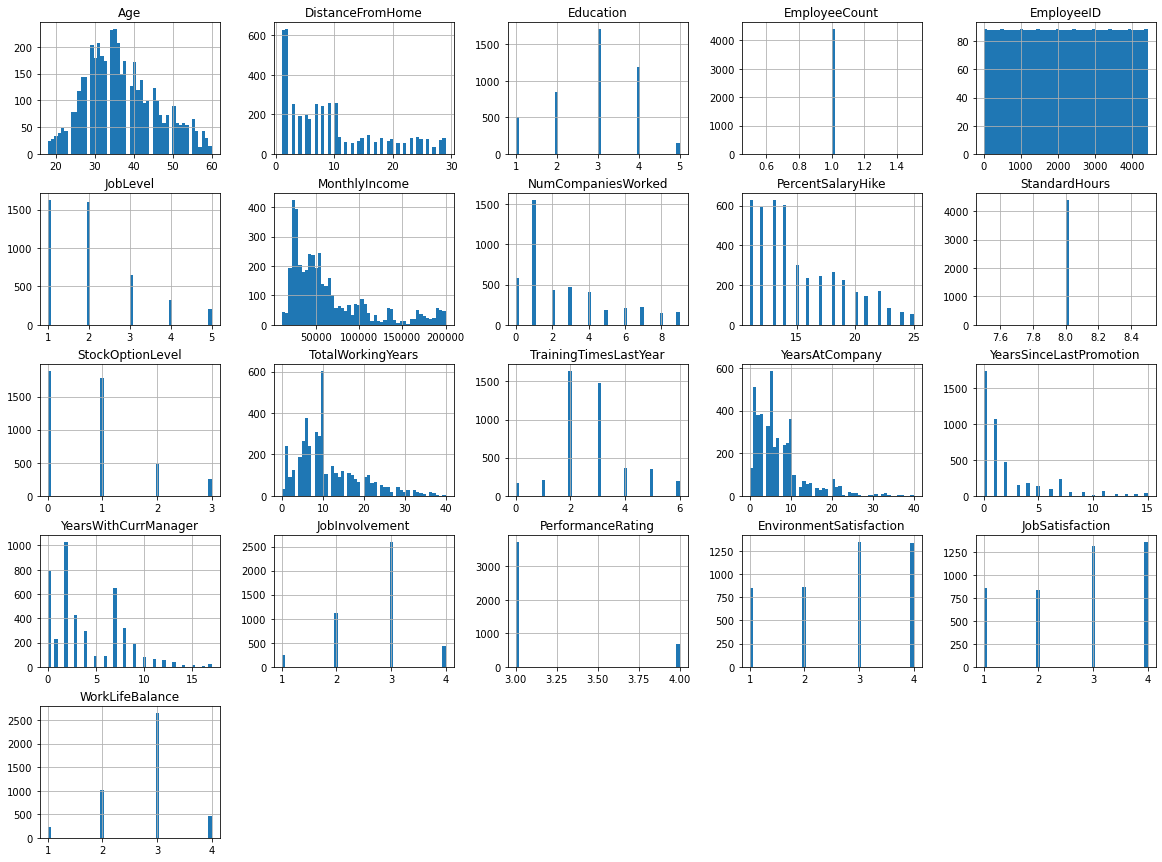

In [19]:
dataset_without_in_out.hist(bins=50, figsize=(20,15))
plt.show()

#### Remarques :

* `EmployeeID` n'a pas d'intéret dans notre jeu de données. Cette colonne est un simple identifiant, un algorithme de machine learning n'en tirera rien.


* On peut voir ici que `EmployeeCount` ne semble pas être une donnée pertinente. En effet l'ensemble des employées était présent en 2015, cela n'aura donc aucun impact sur la prédiction que l'on souhaite faire. Si l'ensemble des employées est "regroupé" sous une même valeurs, cela signifie que cette données est inutile pour notre modèle.


* Il en est de même pour la donnée `StandardHours`. Celle-ci ne semble avoir aucune pertinence puisque l'ensemble des employés ont tous le même nombre d'heures à effectuer au sein d'une journée.


* `PerformanceRating` possède deux "classes" bien distinctes. En effet l'ensemble des données sont regroupées sous deux valeurs : 3 et 4, il serait peut être intéressant de savoir si cette données à un impact direct sur l'attrition.


* Les colonnes `WorkLifeBalance` et `JobInvolvement` ont quasiment les mêmes historgrammes. Il en est de même pour `JobSatisfaction` et `EnvironmentSatisfaction`. Nous allons donc verifier si il existe des corrélations entre ces colonnes.


* Certaines données comme `YearSinceLastPromotion` & `DistanceFromHome` semblent intéressantes à étudier. En effet, on peut voir que beaucoup de personnes qui habitent loin de leur lieu de travail et beaucoup ont été promus récemment, ces données ont potentiellement un impact sur le turn over au sein de la société.


* La colonne `Age` semble ne pas descendre en dessous de 18 ans. Nous allons vérifier cela avec la colonne `Over18` qui est quand à elle une donnée qualitative. Si c'est le cas, alors nous pourrons supprimer la colonne `Over18` car elle ne servirait à rien pour notre modèle.


* Les échelles sont très différentes d'une feature à l'autre. Un scaling sera nécessaire pour obtenir un modèle performant.

Nous pouvons donc supprimer les colonnes `EmployeeID`, `EmployeeCount` et `StandardHours` car elles n'ont pas d'intérêt :

In [20]:
dataset_without_in_out.drop("EmployeeID", axis=1, inplace=True) 
dataset_without_in_out.drop("EmployeeCount", axis=1, inplace=True) 
dataset_without_in_out.drop("StandardHours", axis=1, inplace=True) 

Vérifions maintenant la colonne `Over18` :

In [21]:
dataset_without_in_out["Over18"].value_counts()

Y    4410
Name: Over18, dtype: int64

Nous avons vu juste, les 4410 valeurs sont toutes les mêmes dans cette colonne. Nous pouvons la supprimer.

In [22]:
dataset_without_in_out.drop("Over18", axis=1, inplace=True) 

In [23]:
dataset_without_in_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   JobLevel                 4410 non-null   int64  
 8   JobRole                  4410 non-null   object 
 9   MonthlyIncome            4410 non-null   int64  
 10  NumCompaniesWorked       4391 non-null   float64
 11  PercentSalaryHike        4410 non-null   int64  
 12  StockOptionLevel         4410 non-null   int64  
 13  TotalWorkingYears        4401 non-null   float64
 14  TrainingTimesLastYear   

In [29]:
dataset_without_in_out['Attrition'] = dataset_without_in_out['Attrition'].replace(['Yes','No'],[1,0])
dataset_without_in_out.head().style

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,1.000000,11,0,1.000000,6,1,0,0,3,3,3.000000,4.000000,2.000000
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,0.000000,23,1,6.000000,3,5,1,4,2,4,3.000000,2.000000,4.000000
2,32,0,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,1.000000,15,3,5.000000,2,5,0,3,3,3,2.000000,2.000000,1.000000
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,3.000000,11,3,13.000000,5,8,7,5,2,3,4.000000,4.000000,3.000000
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,4.000000,12,2,9.000000,2,6,0,4,3,3,4.000000,1.000000,3.000000


#### C.3 Étude des corrélations

In [30]:
corr_matrix = dataset_without_in_out.corr()
corr_matrix["Attrition"]

Age                       -0.159205
Attrition                  1.000000
DistanceFromHome          -0.009730
Education                 -0.015111
JobLevel                  -0.010290
MonthlyIncome             -0.031176
NumCompaniesWorked         0.042345
PercentSalaryHike          0.032533
StockOptionLevel          -0.006839
TotalWorkingYears         -0.170338
TrainingTimesLastYear     -0.049431
YearsAtCompany            -0.134392
YearsSinceLastPromotion   -0.033019
YearsWithCurrManager      -0.156199
JobInvolvement            -0.015588
PerformanceRating          0.023403
EnvironmentSatisfaction   -0.102142
JobSatisfaction           -0.102847
WorkLifeBalance           -0.062756
Name: Attrition, dtype: float64

array([[<AxesSubplot:xlabel='Attrition', ylabel='Attrition'>,
        <AxesSubplot:xlabel='NumCompaniesWorked', ylabel='Attrition'>,
        <AxesSubplot:xlabel='PercentSalaryHike', ylabel='Attrition'>,
        <AxesSubplot:xlabel='PerformanceRating', ylabel='Attrition'>],
       [<AxesSubplot:xlabel='Attrition', ylabel='NumCompaniesWorked'>,
        <AxesSubplot:xlabel='NumCompaniesWorked', ylabel='NumCompaniesWorked'>,
        <AxesSubplot:xlabel='PercentSalaryHike', ylabel='NumCompaniesWorked'>,
        <AxesSubplot:xlabel='PerformanceRating', ylabel='NumCompaniesWorked'>],
       [<AxesSubplot:xlabel='Attrition', ylabel='PercentSalaryHike'>,
        <AxesSubplot:xlabel='NumCompaniesWorked', ylabel='PercentSalaryHike'>,
        <AxesSubplot:xlabel='PercentSalaryHike', ylabel='PercentSalaryHike'>,
        <AxesSubplot:xlabel='PerformanceRating', ylabel='PercentSalaryHike'>],
       [<AxesSubplot:xlabel='Attrition', ylabel='PerformanceRating'>,
        <AxesSubplot:xlabel='NumCompanie

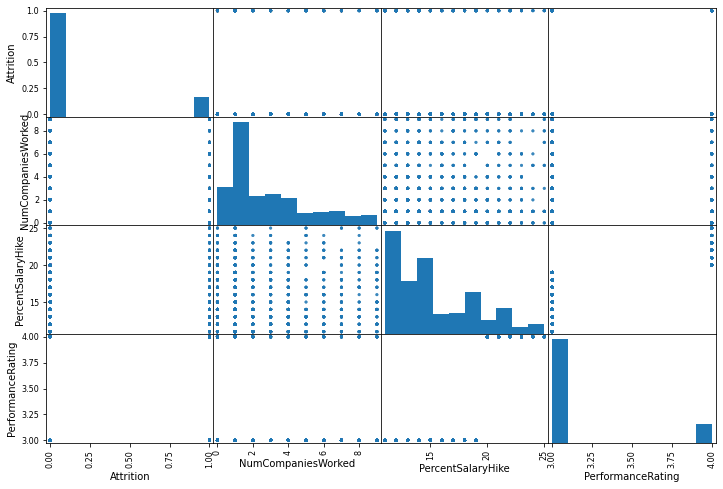

In [32]:
from pandas.plotting import scatter_matrix

attributes = ["Attrition", "NumCompaniesWorked", "PercentSalaryHike","PerformanceRating"]
scatter_matrix(dataset_without_in_out[attributes], figsize=(12, 8))

<AxesSubplot:xlabel='Attrition', ylabel='NumCompaniesWorked'>

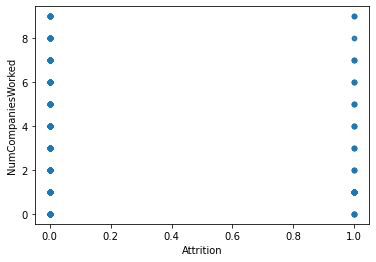

In [33]:
dataset_without_in_out.plot(kind="scatter", x="Attrition", y="NumCompaniesWorked",
             alpha=0.1)

#### C.4 Étude des horaires d'entrées / sorties

Les données d'entrées / sorties fournies par les badgeuses de l'entreprise sont assez indigestes et n'ont pas de valeur significative pour un algorithme de machine learning dans leur forme actuelle. Nous avons donc décidé d'essayer de faire une moyenne du nombre d'heure travaillées, par jour, d'un employé entre le `01/01/2015` et le `31/12/2015`

Nous commencons par récuperer un tableau contenant uniquement les données d'entrées / sorties depuis notre `dataset`

In [ ]:
dataset_with_in_out = dataset.drop(dataset.iloc[:, 0:29],1)

Nous allons maintenant transformer toutes ces données étant de type `string` en `datetime`

In [ ]:
dataset_with_in_out = dataset_with_in_out.apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

Il est maintenant nécessaire de "soustraire" les sorties des entrées des employés pour obtenir le temps qu'ils ont passés, par jour, sur leur lieu de travail

In [ ]:
import datetime as dt
import pandas as pd

nombre_de_jour = int(dataset_with_in_out.shape[1] / 2)

datetime_in = dataset_with_in_out.drop(dataset_with_in_out.iloc[:, nombre_de_jour:],1)
datetime_out = dataset_with_in_out.drop(dataset_with_in_out.iloc[:, :nombre_de_jour],1)

datetime_in.columns = datetime_in.columns.str.rstrip("_in")
datetime_out.columns = datetime_out.columns.str.rstrip("_out")

datetime_sub = datetime_out.subtract(datetime_in, fill_value=0)

Nous pouvons maintenant faire la moyenne du temps que chaque employés à passé sur son lieu de travail par jour entre le `01/01/2015` et le `31/12/2015`, en secondes.

In [ ]:
datetime_mean = datetime_sub.mean(axis = 1)
datetime_mean = datetime_mean.dt.total_seconds()
datetime_mean

Les données d'entrées et de sorties sont maintenant beaucoup plus exploitable par un algorithme de machine learning. Nous allons donc les remettres dans notre `dataset`.

In [ ]:
final_dataset = dataset_without_in_out
final_dataset["MoyenneInOut"] = datetime_mean

final_dataset.info()

#### C.5 Création des jeux d'entrainement et de test

Nous allons découper notre jeu de données en deux avec une séparation de 80%.

* Le `train_set` contiendra 80% de nos données. Le modèle de machine learning s'entrainera sur ces données.
* Le `test_set` contiendra 20% de nos données. Le modèle de machine sera testé sur ces données.

Nous allons  faire un échantillonage stratifié sur la donnée `Attrition` pour que le `train_set` et le `test_set` possèdent les mêmes proportions de personnes qui sont restées et qui sont parties de l'entreprise.

Vérifions les proportions :

In [ ]:
final_dataset["Attrition"].hist()

On peut maintenant utiliser [`StratifiedShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) pour échantillonner le jeu de données en respectant notre contrainte :

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #initialise le split

for train_index, test_index in split.split(final_dataset, final_dataset["Attrition"]): 
    train_set = dataset_without_in_out.loc[train_index]
    test_set = dataset_without_in_out.loc[test_index]

Nous vérifions maintenant si les proportions ont bien été respectées :

In [ ]:
train_set["Attrition"].hist()

In [ ]:
test_set["Attrition"].hist()

Nos histrogrammes semblent avoir les mêmes proportions. Notre stratification a donc bien fonctionnée.

### D. Préparation des données d'entrainement pour les algorithmes de ML

Nous allons commencer par scinder le jeu de données d'entrainement. D'une part nous aurons, les variables-cibles, ou "labels", notées $Y$ et de l'autre, les "features" notées $X$.

In [ ]:
train_set_features = train_set.drop("Attrition", axis=1)
train_set_labels = train_set["Attrition"].copy()

#### D.1 Identifications des données numériques et qualitative

In [ ]:
train_set_features_num = train_set_features.select_dtypes(include=[np.number]) # recupère les données des colonnes numerique uniquement
train_set_features_cat = train_set_features.select_dtypes(exclude=[np.number]) # recupère les donnée

train_set_features_num = list(train_set_features_num)
train_set_features_cat = list(train_set_features_cat)

#### D.2  Pipeline des données qualitatives

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('cat_encoder', OneHotEncoder())
])

#### D.2  Pipeline des données numériques

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imput', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

#### D.3  Pipeline de préparation des données

In [ ]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, train_set_features_num),
        ("cat", cat_pipeline, train_set_features_cat),
    ])

In [ ]:
train_set_features_prepared = full_pipeline.fit_transform(train_set_features)

In [ ]:
BusinessTravel_list = list(set(train_set_features['BusinessTravel']))
BusinessTravel_list.reverse()
BusinessTravel_list = [sub + '_BusinessTravel' for sub in BusinessTravel_list] 

Department_list = list(set(train_set_features['Department']))
Department_list.reverse()   
Department_list = [sub + '_Department' for sub in Department_list] 

EducationField_list = list(set(train_set_features['EducationField']))
EducationField_list.reverse()
EducationField_list = [sub + '_EducationField' for sub in EducationField_list] 

JobRole_list = list(set(train_set_features['JobRole']))
JobRole_list.reverse()
JobRole_list = [sub + '_JobRole' for sub in JobRole_list] 

train_set_features_prepared_pd = pd.DataFrame(
    train_set_features_prepared,
    columns = train_set_features_num + BusinessTravel_list + Department_list + EducationField_list + JobRole_list)

train_set_features_prepared_pd.head().style

In [ ]:
train_set_features_prepared_pd.boxplot(train_set_features_num, figsize=(40,30))

# 2. Choix d'un modèle de machine learning